In [1]:
import numpy as np
import pandas as pd

from envs.bess_env import BatteryEnv
from utils.rule_based_controller import RuleBasedController
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.eval_handler import evaluate_financials, evaluate_rollout
from scenarios.price_scenario import PriceScenarioGenerator

In [2]:
# === Load training data: full November 2024 ===
df_train, price_train, timestamps_train = load_price_data(
    csv_path="../data/raw/dayahead_2024_11.csv",
    resolution="15min",
)

# === Load evaluation data: first week of November 2025 ===
df_eval, price_eval, timestamps_eval = load_price_data(
    csv_path="../data/raw/dayahead_2025_11.csv",
    resolution="15min",
    time_range=("2025-11-01", "2025-11-07"),
)

print(len(price_eval), "time steps in a week (should be 672)")
print("Week from", timestamps_eval[0], "to", timestamps_eval[-1])

672 time steps in a week (should be 672)
Week from 2025-11-01 00:00:00+01:00 to 2025-11-07 23:45:00+01:00


Episode finished early at step 671
=== Financial Summary ===
Total revenue    (EUR): 8.636
Degradation cost (EUR): 0.382
Penalty cost     (EUR): 0.000
Total reward     (EUR): 8.254


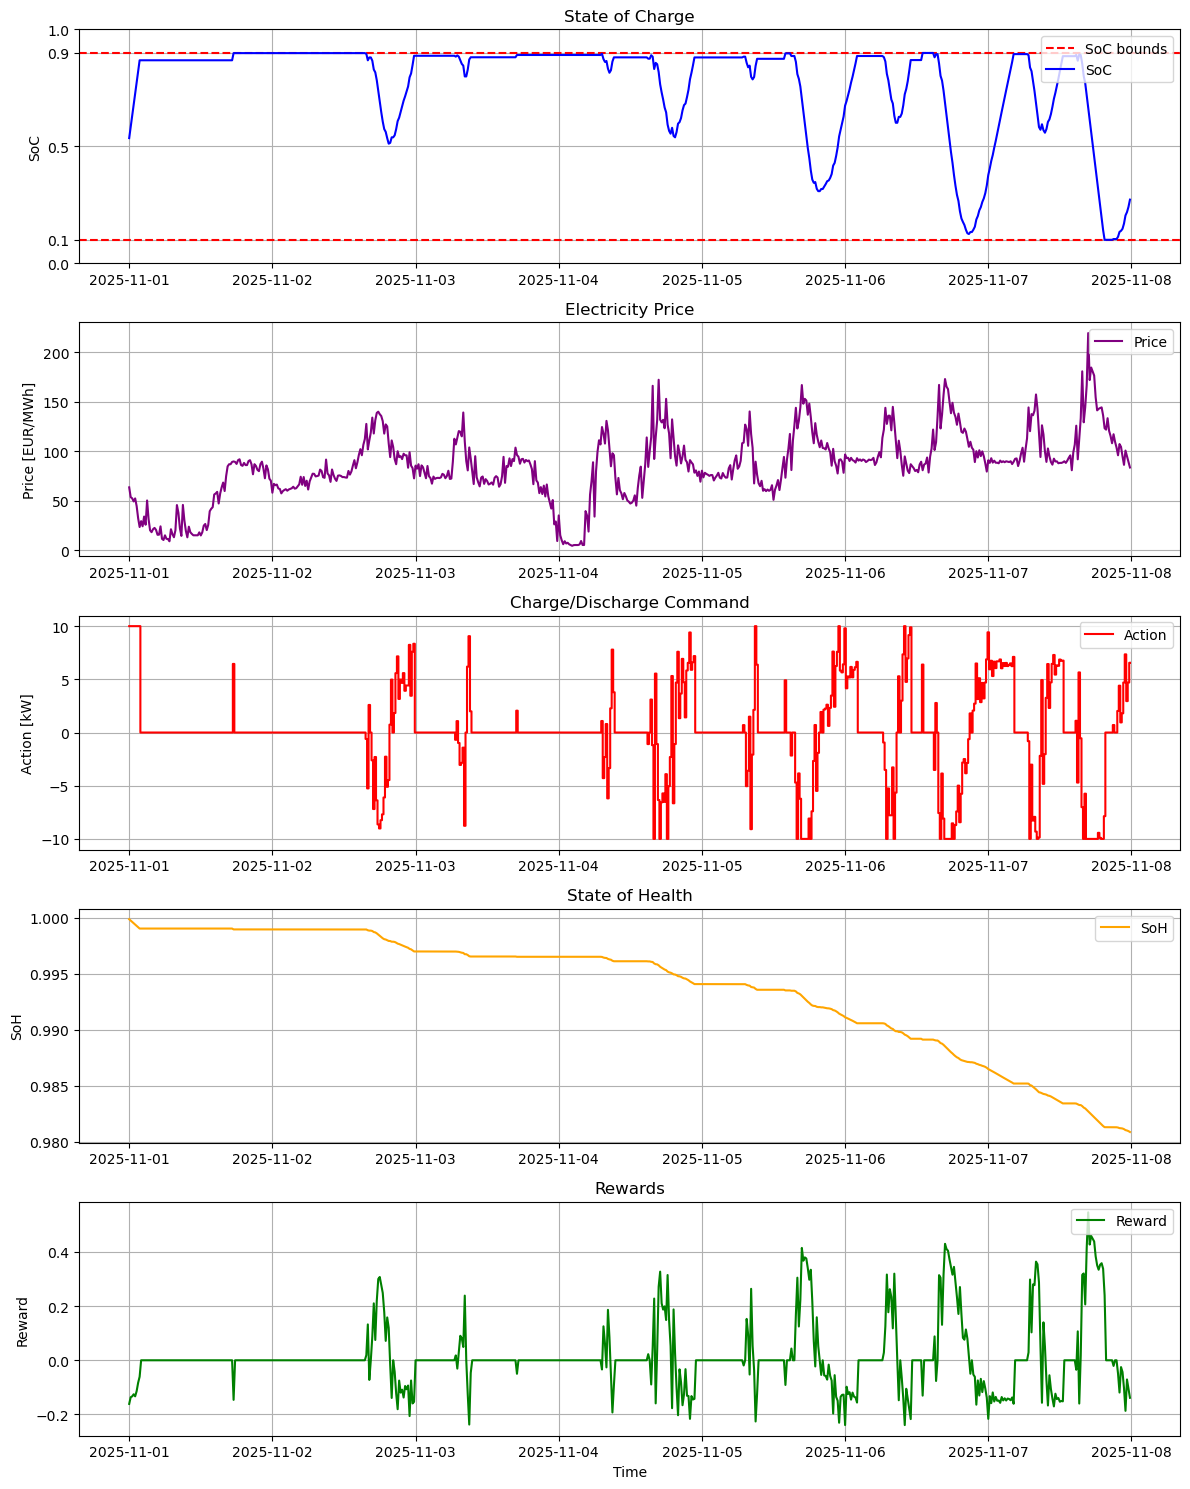

In [3]:
# --------------------------------------------------
# Price forecast uncertainty scenarios (deterministic)
# --------------------------------------------------
forecast_horizon_hours=3.0
dt_hours=0.25
forecast_horizon_steps = int(round(forecast_horizon_hours / dt_hours))  # 3h forecast, 15 min steps → 12 steps

price_scenario_gen = PriceScenarioGenerator(
    horizon_steps=forecast_horizon_steps,
    sigma0=0.01,   # small uncertainty for near future
    sigmaH=0.06,   # larger uncertainty for further future
    schedule="sqrt",   # realistic growth
    base_seed=1234,    # IMPORTANT: same seed = same scenarios
)

env_cont = BatteryEnv(
    price_series=price_eval,
    demand_series=None,
    timestamps=timestamps_eval,
    dt_hours=0.25,              # 15-minute steps
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,
    use_price_forecast=True,
    forecast_horizon_hours=forecast_horizon_hours,
    random_seed=42,
)

rb_controller_cont = RuleBasedController(env=env_cont, price_history=price_train) # Instantiate Rule Based Controller

results = evaluate_rollout(
    model=rb_controller_cont,
    env=env_cont,
)

evaluate_financials(
    revenue_list=results["revenue"],
    deg_cost_list=results["deg_cost"],
    penalty_list=results["penalty"],
)

plot_bess_rollout(
    soc_list=results["soc"],
    soh_list=results["soh"],
    reward_list=results["reward"],
    price_list=results["price_true"],
    action_list=results["action"],
    timestamps=timestamps_eval,
)